In [10]:
library(dplyr)
library(basemaps)
library(ggplot2)
library(sf)
library(ozmaps)
library(stringr)

#library(treemapify)
#library(lubridate)
#library(ggrepel)
#library(igraph)
#library(ggraph)
#library(ggpubr)
#library(forcats)
#library(ggforce)
#library(tidyr)



In [11]:

here::i_am("spatial-coverage/explore-survey-locs.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



In [12]:
data_dir <- here::here("data")
site_locs <- read_sf(here::here(data_dir,"field-sites.gpkg"))

In [13]:



# use pseudomercator projection 3857
nsw <- st_transform(ozmaps::ozmap_states, 3857) %>% filter(NAME == "New South Wales")
okabe <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

new_surveys <- site_locs |> filter(!survey_name %in% c("TO BE CLASSIFIED", "Mallee Woodlands")) |> st_drop_geometry() 
old_surveys <- site_locs |> filter(survey_name %in% c( "Mallee Woodlands")) |> st_drop_geometry() 



In [14]:
## Read API Key from here
readRenviron(here::here("secrets","Renviron.local"))

In [17]:
excluded <- c( "TO BE CLASSIFIED")

field_surveys <- site_locs %>% 
  filter(!survey_name %in% excluded) %>%
  st_transform(3857)


In [18]:

survey_cts <- field_surveys %>% 
  mutate(survey_description = str_replace_all(survey_description, "RF", "Rainforests")  %>%
  str_replace_all("NP", "National Park") %>%
  str_replace_all("NE NSW & SE Qld", "North Eastern NSW")
    ) %>%
  group_by(survey_name,survey_description) %>% 
  summarise(
    nsites=n(),
    min_elev=min(elevation,na.rm=T),
    max_elev=max(elevation,na.rm=T),
    geom=st_union(geom),.groups='keep') %>% 
  st_centroid 

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `min_elev = min(elevation, na.rm = T)`.
ℹ In group 3: `survey_name = "Mallee Woodlands"` and `survey_description =
  "Mallee Woodlands"`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [19]:


xys <- st_coordinates(survey_cts) %>% data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts %>% 
  transmute(
    description=sprintf("%s (%s sites, %s – %s m)",
      survey_description, nsites, min(pretty(min_elev)), max(pretty(max_elev))
    )) %>%
  pull(description)


Warning message:
“There were 2 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `description = sprintf(...)`.
ℹ In group 3: `survey_name = "Mallee Woodlands"` and `survey_description =
  "Mallee Woodlands"`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [30]:
st_bbox(st_buffer(nsw,50000))

    xmin     ymin     xmax     ymax 
15645966 -4559732 17151997 -3218793 

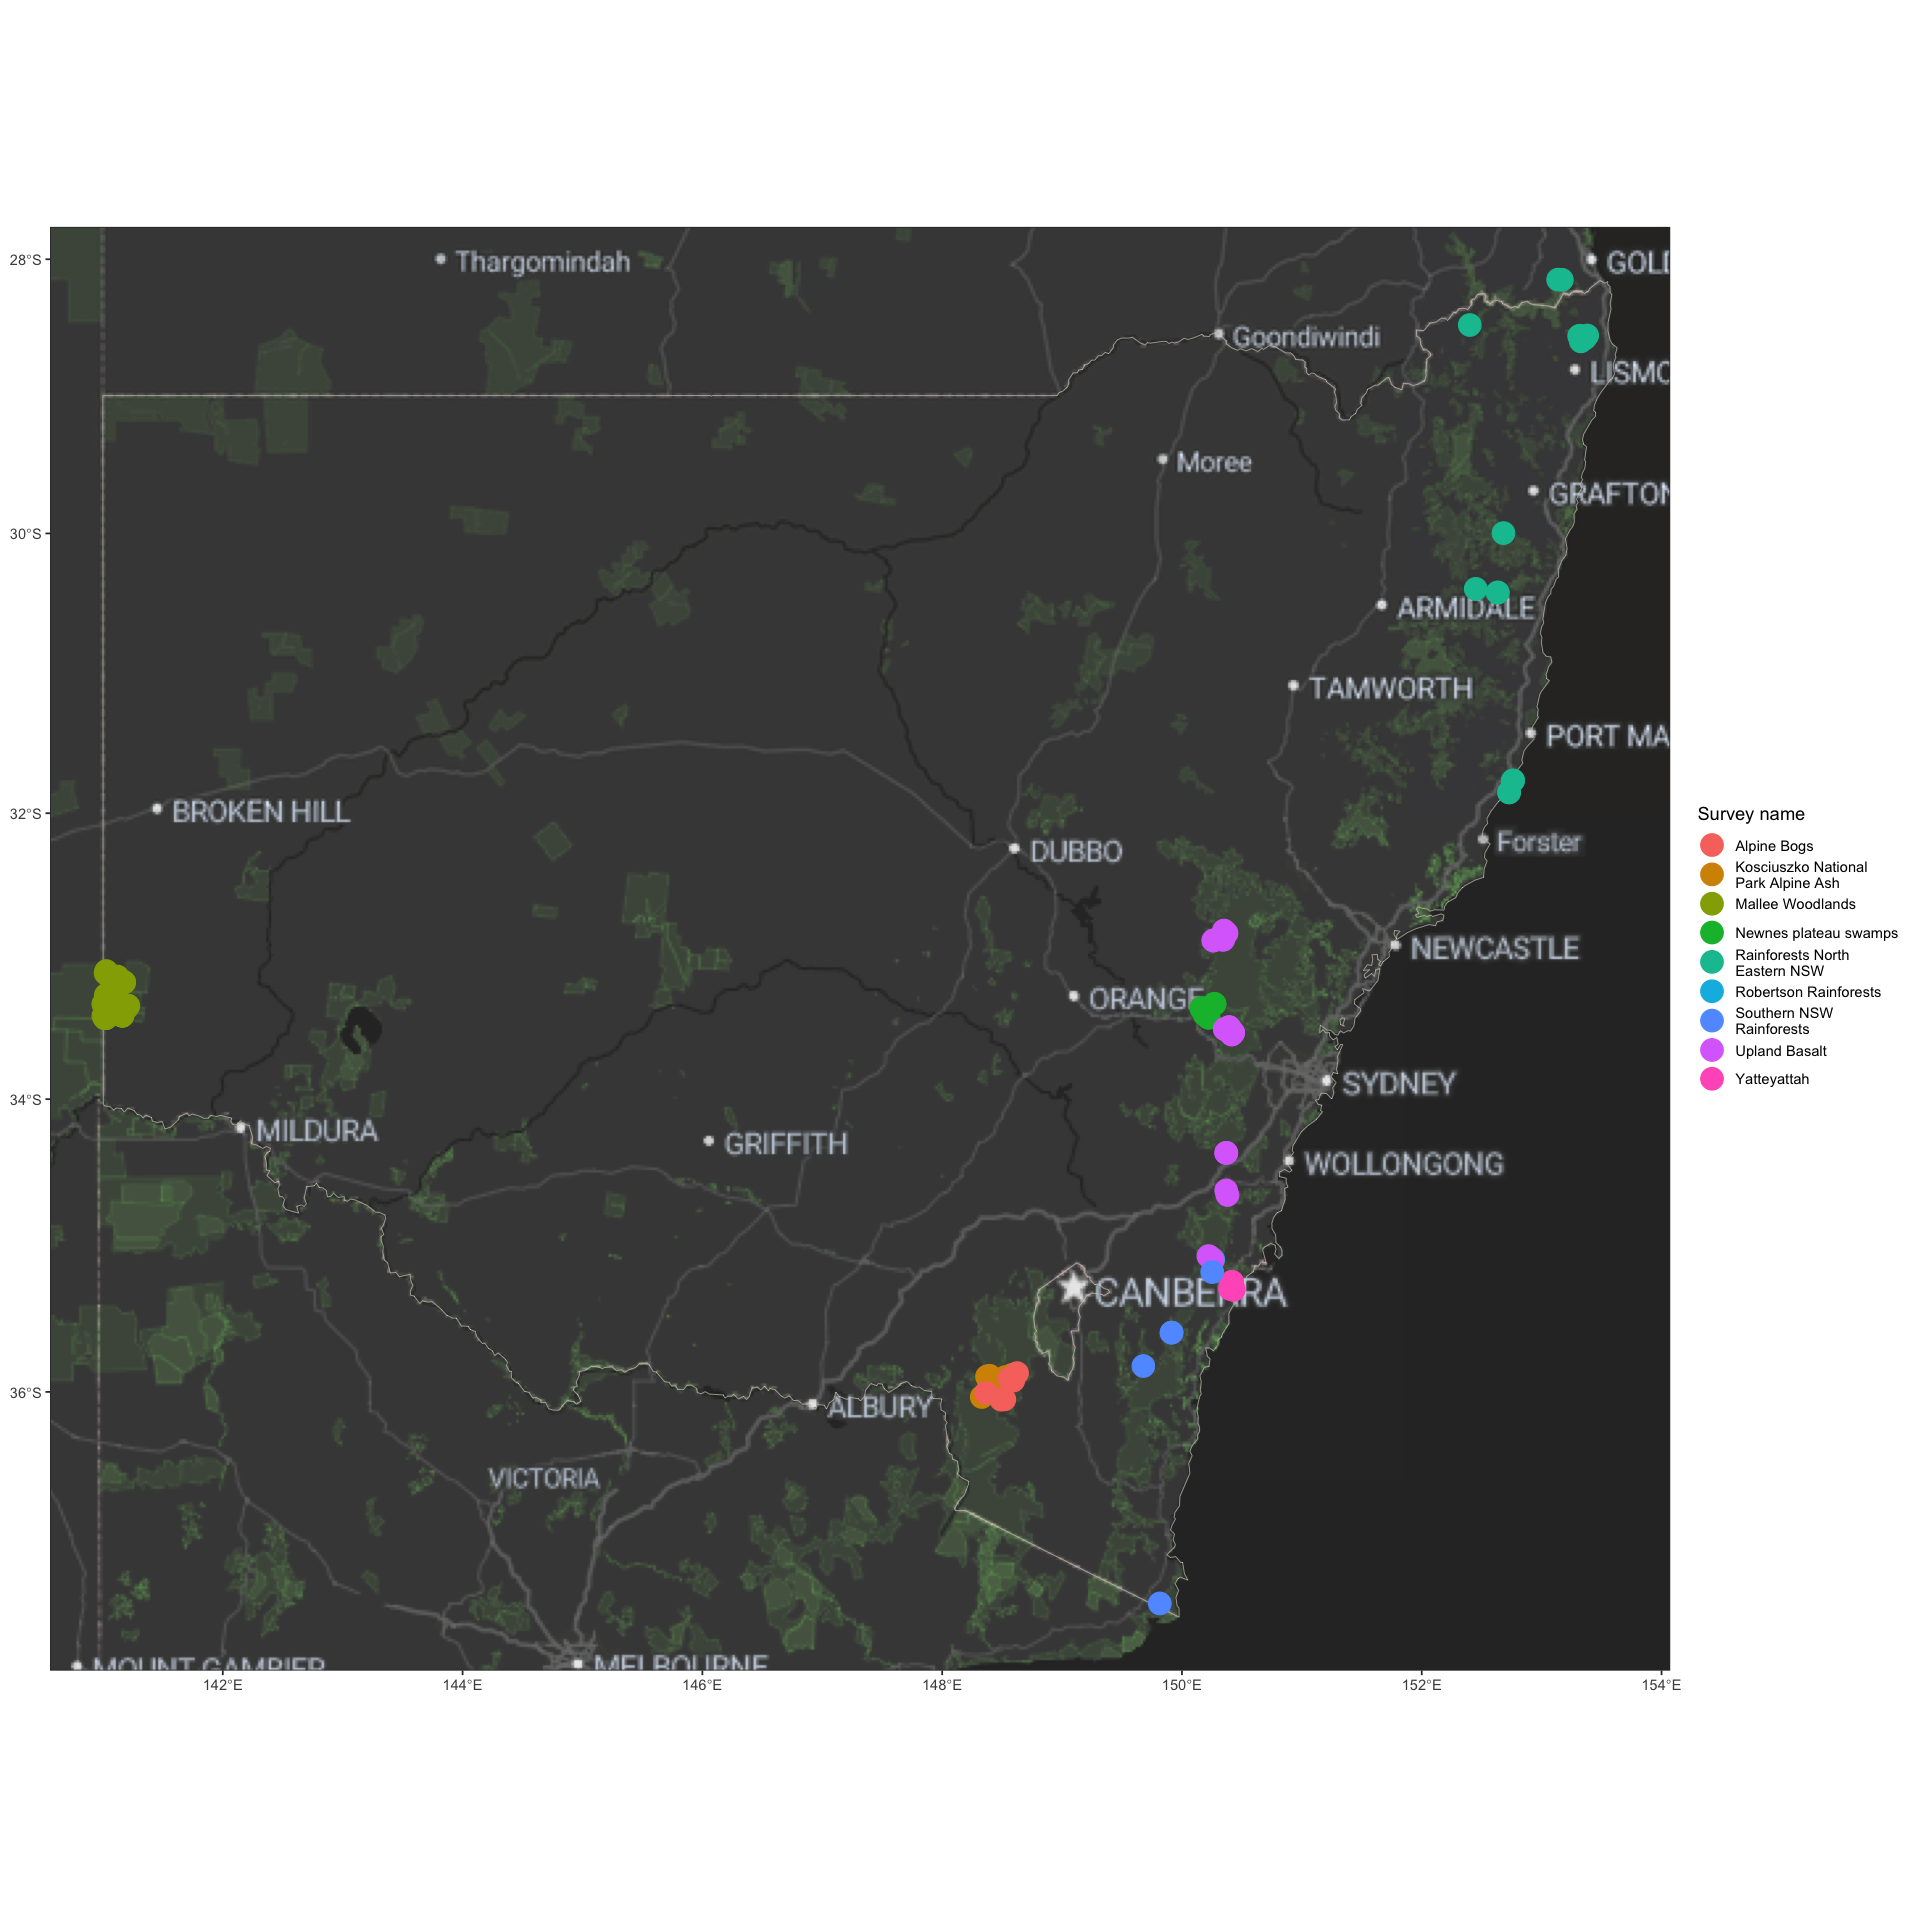

In [33]:
options(repr.plot.width=16,repr.plot.height=16) # Make plot larger
ggplot() + 
        basemap_gglayer(st_bbox(st_buffer(nsw,50000)),
          map_dir = data_dir,
          map_service = "osm_stadia", 
          map_type = "alidade_smooth_dark", 
          map_token = Sys.getenv("STADIA_API_KEY"),
          verbose = FALSE) +
        scale_fill_identity() + 
        geom_sf(data = nsw, fill = NA, colour = 'ivory3') +
        geom_sf(data=field_surveys,aes(colour=survey_name), size=6) + 
        #geom_label_repel(data=xys,
        #                 size=2.75,
        #                 nudge_x = 10,
        #                 nudge_y = 1,
                         #direction = "y",
        #                 aes(label=survey_desc
        #                     , colour=survey_name,x=X,y=Y)) +
          scale_colour_discrete(
            labels = str_wrap(survey_cts$survey_description,22),
            #labels = str_wrap(xys$survey_desc, 18),
              guide = guide_legend(
                title = "Survey name",
                byrow = TRUE,
                theme = theme(
                #legend.direction = "horizontal",
                legend.spacing.y = unit(3.0, 'cm'),
                legend.title.position = "top",
                #legend.text.position = "top",
                #legend.text = element_text(hjust = 0.5, vjust = 0.5)
          ))) +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(expand = c(0, 0)) +
        theme_bw() +
        theme(legend.position = "right",
              axis.title.x = element_blank(),
              axis.title.y = element_blank()
        )